<a href="https://colab.research.google.com/github/nengelmann/Fuyu-8B---Exploration/blob/main/Fuyu_8B_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fuyu-8B Exploration 🤓 🔍**

**Explore** the capabilities of **fuyu-8b** for memes and other use cases.

## Installation 💿

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q bitsandbytes accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 19.7 MB/s eta 0:00:00


## Imports ↙️

In [2]:
import time
import cv2
import numpy as np
import torch
from google.colab.patches import cv2_imshow
from urllib.request import Request, urlopen
from transformers import AutoTokenizer, FuyuProcessor, FuyuImageProcessor, FuyuForCausalLM, BitsAndBytesConfig

## Helper functions ⚒️

In [3]:
def url_to_image(url):
  """get image from web url"""
  #definition of User-Agent in header due to website blocking, also see here: https://stackoverflow.com/questions/16627227/problem-http-error-403-in-python-3-web-scraping
  req = Request(url=url, headers={'User-Agent': 'Mozilla/6.0'})
  resp = urlopen(req).read()
  image = np.asarray(bytearray(resp), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  return image

def show(image):
  """show an image in line"""
  cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

def pprint(text, line_char=88):
  """pretty print text by limit line characters"""
  last_char = "" # handle last word in each line
  for i in range(0, len(text), line_char):
    line = text[i:i+line_char]
    line = last_char+line
    last_char = ""
    line = line.split(" ")
    last_char = line[-1]
    if i <= len(text)-line_char:
      # handle last word in last line
      line = line[:-1]
    print(" ".join(line))

def run_example(prompt, img_url):
  """run example with prompt and image url"""
  # get and show image
  image = url_to_image(img_url)
  show(image)
  # run the model
  output = fuyu.prompt(prompt, image, out_tokens=100)
  # pretty print example info
  pprint(f"\nGiven \x1b[1;31mimage\x1b[0m \x1B[3m{img_url}\x1B[0m \x1b[1;31mand\x1b[0m the following \x1b[1;31mprompt\x1b[0m:\n\n\x1B[3m{prompt}\x1B[0m", 80)
  pprint(f"The \x1b[1;31mmodels output\x1b[0m:\n\n\x1B[3m{output}\x1B[0m\n", 88)



## Model definition ⚙️

In [10]:
# check runtime type
if torch.cuda.is_available():
  model_id="ybelkada/fuyu-8b-sharded"
  print(f"\nUsing the sharded model '{model_id}' with to GPU usage.\n")
  print("This model is faster due to 4bit quantization and GPU computation. 🚀\n")
else:
  model_id="adept/fuyu-8b"
  print(f"\nUsing the original model '{model_id}' without GPU usage.\n")
  print("This model, as of today, can't be 4bit quantized. Also the weights can't be fully loaded into memory in colab free tier.")
  print("Running it on CPU and without the above optimizations makes it extremely slow in computation, however you can still do it and run this 8 billion parameter model!\n")
  print("⚠️ For the sake of time, consider switching the runtime type to 'T4 GPU' or any other GPU type.\n")



Using the original model 'adept/fuyu-8b' without GPU usage.

This model, as of today, can't be 4bit quantized. Also the weights can't be fully loaded into memory in colab free tier.
Running it on CPU and without the above optimizations makes it extremely slow in computation, however you can still do it and run this 8 billion parameter model!

⚠️ For the sake of time, consider switching the runtime type to 'T4 GPU' or any other GPU type.



In [11]:
class Fuyu():
    """Pretrained fuyu model of Adept via huggingface"""

    def __init__(self, model_id="ybelkada/fuyu-8b-sharded"):
        # check if GPU can be used
        if torch.cuda.is_available():
            print("You are running the model on GPU.")
            self.device = torch.device("cuda")
            self.dtype = torch.float16
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=self.dtype
            )
            self.model = FuyuForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)
        else:
            print("You are running the model on CPU, the runtime might be very slow. 🐌")
            self.device = torch.device("cpu")
            self.dtype = torch.bfloat16
            # 4bit quantization is currently not working with the latest version of transformers (as of today: 4.35.0.dev0), it is working with transformers 4.30, however fuyu is not integrated there.
            self.model = FuyuForCausalLM.from_pretrained(model_id, device_map=self.device, torch_dtype=self.dtype)

        # initialize tokenizer and fuyu processor, pretrained and via huggingface
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.processor = FuyuProcessor(image_processor=FuyuImageProcessor(), tokenizer=self.tokenizer)

    def prompt(self, text, image=None, out_tokens=50):
        """Prompt the model with a text and optional an image prompt."""

        if image is None:
            # if no image is provided, use a small black image
            # Warning: This is working but the model is not trained on this image fake. Test purpose only!
            image = np.zeros((30,30,3), dtype=np.uint8)

        # pre processing image and text
        inputs = fuyu.processor(text=text, images=[image], return_tensors="pt")
        inputs = {k: v.to(dtype=self.dtype if torch.is_floating_point(v) else v.dtype, device=self.device) for k,v in inputs.items()}
        prompt_len = inputs["input_ids"].shape[-1]

        # process
        t0 = time.time()
        generation_output = fuyu.model.generate(**inputs, max_new_tokens=out_tokens, pad_token_id=self.tokenizer.eos_token_id)
        print(f"\nGeneration time: {time.time()-t0:.0f}s")

        # post processing
        generation_text = self.tokenizer.decode(generation_output[0][prompt_len:], skip_special_tokens=True)
        return generation_text.lstrip()

## Model instantiation ⏳

This might run a few minutes while downloading the weights. \
Time for a coffee! ☕

**If the execution fails** 💥, it is likely an out of memory error of CUDA (GPU) or your system RAM.
You should disconnect and delete the current runtime environment, then re-run all cells.

In [12]:
fuyu = Fuyu(model_id)

You are running the model on CPU, the runtime might be very slow. 🐌


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Meme Examples 😂


### Meme: Face palm - "I can't even"

[Example](https://memecomplete.com/edit/images/facepalm/_/I_can't_even.png%3Ftoken=yt2ys5jsfx72zoi11jnh) from [Memegen.link](https://memegen.link/examples/)

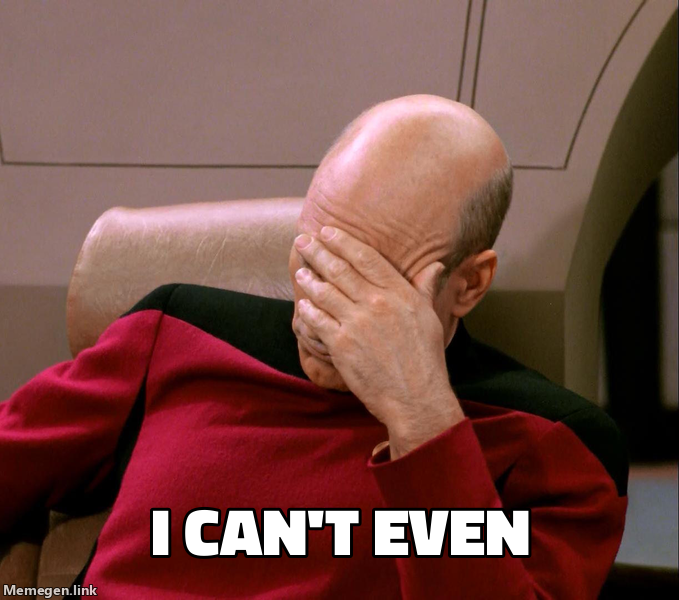

In [ ]:
prompt = "Extract the text contained within the image. The extracted text in relation to the image content represent a joke or funny situation. Explain why it is funny.\n"
img_url = "https://api.memegen.link/images/facepalm/_/I_can't_even.png"

run_example(prompt, img_url)

### Meme: What year is it?

[Example](https://memecomplete.com/edit/images/whatyear/_/what_year_is_it~q.png%3Ftoken=miijb4kvs9jeb0uddvzt) from [Memegen.link](https://memegen.link/examples/)

In [ ]:
prompt = "Extract the text contained within the image. The extracted text in relation to the image content represent a joke or funny situation. Explain why it is funny.\n"
img_url = "https://api.memegen.link/images/whatyear/_/what_year_is_it~q.png"

run_example(prompt, img_url)

### Meme: Someone on the internet disagrees
[Example](https://memecomplete.com/edit/images/fwp/someone_on_the_internet/disagrees_with_me.png%3Ftoken=m9yv0xjn09jeb0uddvzt) from [Memegen.link](https://memegen.link/examples/)

In [ ]:
prompt = "Extract the text contained within the image. The extracted text in relation to the image content represent a joke or funny situation. Explain why it is funny.\n"
img_url = "https://api.memegen.link/images/fwp/someone_on_the_internet/disagrees_with_me.png"

run_example(prompt, img_url)

### Meme: Have you ever eaten a clock

[Example](https://memecomplete.com/edit/images/captain-america/Have_you_ever_eaten_a_clock~q/No,_why~q/It's_time_consuming..png%3Ftoken=cdilu5l4f4e96vp88quo) from [Memegen.link](https://memegen.link/examples/)

In [ ]:
prompt = "Extract the text contained within the image. The extracted text in relation to the image content represent a joke or funny situation. Explain why it is funny.\n"
img_url = "https://api.memegen.link/images/captain-america/Have_you_ever_eaten_a_clock~q/No,_why~q/It's_time_consuming..png"

run_example(prompt, img_url)

### Meme: Noah - "What the hell is this?"

[Example](https://memecomplete.com/edit/images/noah/Street/Road/Stroad/What_the_hell_is_this~q.png%3Ftoken=oa7pk4hfoakfc1veew0u) from [Memegen.link](https://memegen.link/examples/)

In [ ]:
prompt = "Extract the text contained within the image. The extracted text in relation to the image content represent a joke or funny situation. Explain why it is funny.\n"
img_url = "https://api.memegen.link/images/noah/Street/Road/Stroad/What_the_hell_is_this~q.png"

run_example(prompt, img_url)

### Meme: Engineer - "Is this Photoshop?"

[Example](https://memecomplete.com/edit/images/pigeon/Engineer/PowerPoint/Is_this_Photoshop~q.png%3Ftoken=slz67cqqdcmhe3xggy2w) from [Memegen.link](https://memegen.link/examples/)

In [ ]:
prompt = "Extract the text contained within the image. The extracted text in relation to the image content represent a joke or funny situation. Explain why it is funny.\n"
img_url = "https://api.memegen.link/images/pigeon/Engineer/PowerPoint/Is_this_Photoshop~q.png"

run_example(prompt, img_url)

### Meme: Just Graduated? - "You must know everything"

[Example](https://memecomplete.com/edit/images/wonka/oh,_you_just_graduated~q/you_must_know_everything.png%3Ftoken=e87k5c7t65fa7wq99rvp) from [Memegen.link](https://memegen.link/examples/)

In [ ]:
prompt = "Extract the text contained within the image. The extracted text in relation to the image content represent a joke or funny situation. Explain why it is funny.\n"
img_url = "https://api.memegen.link/images/wonka/oh,_you_just_graduated~q/you_must_know_everything.png"

run_example(prompt, img_url)

### Meme: Monday Slap - "Me trying to enjoy the weekend"

[Example](https://memecomplete.com/edit/images/slap/Me_Trying_to_Enjoy_the_Weekend/Monday.png%3Ftoken=qiyelixapblgd2wffx1v) from [Memegen.link](https://memegen.link/examples/)

In [ ]:
prompt = "Extract the text contained within the image. The extracted text in relation to the image content represent a joke or funny situation. Explain why it is funny.\n"
img_url = "https://api.memegen.link/images/slap/Me_Trying_to_Enjoy_the_Weekend/Monday.png"

run_example(prompt, img_url)

## Try it yourself 🫵

Choose an online image link, define your promt and see what happens!

In [ ]:
prompt= "Explain what objects are in this image."        #@param {type:"string"}
image_url = "https://learnopencv.com/wp-content/uploads/2021/04/image-15.png"        #@param {type:"string"}
out_tokens = 50           #@param {type:"slider", min:0, max:100, step:1}

# show image
image = url_to_image(img_url)
show(image)

# run model
output = fuyu.prompt(prompt, image, out_tokens=out_tokens)
pprint(output)

## Use the model directly 🤓

In [ ]:
prompt = "What do you think about this stunning view?"
img_url = "https://scx2.b-cdn.net/gfx/news/hires/2022/an-image-of-the-carina.jpg"

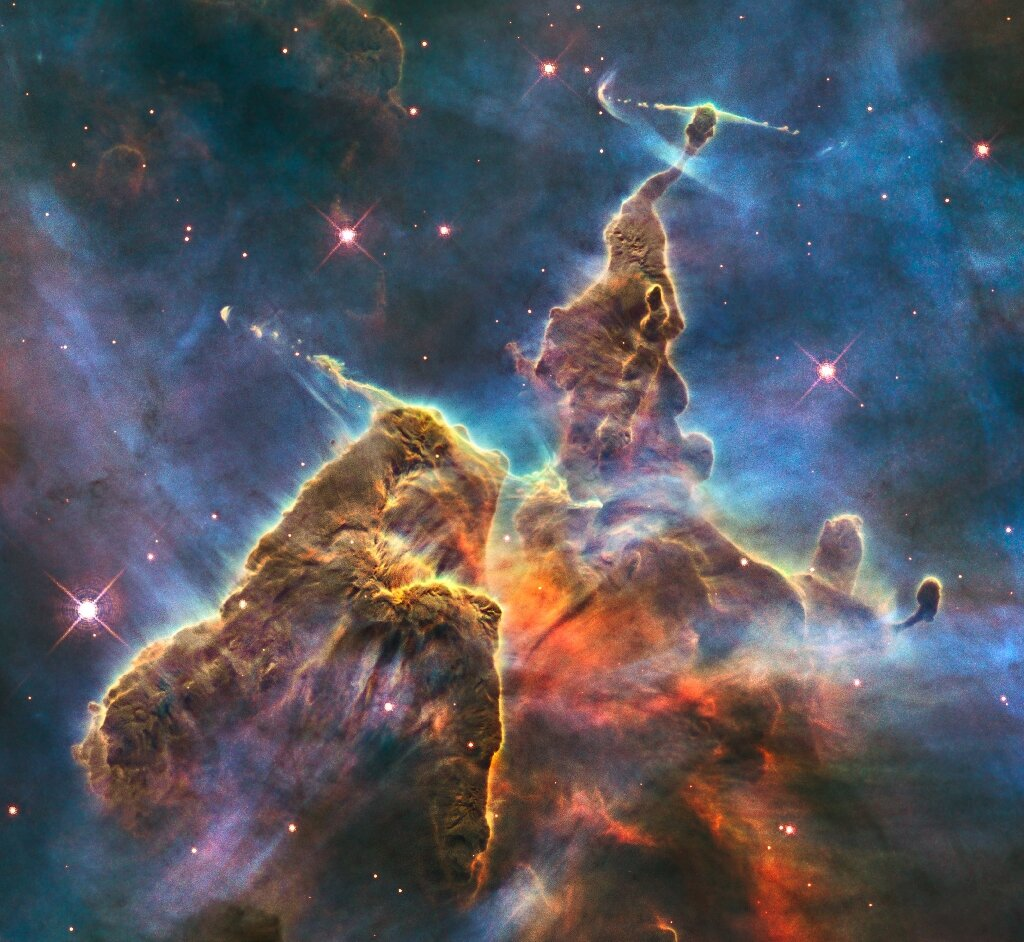

In [ ]:
image = url_to_image(img_url)
show(image)

In [ ]:
output = fuyu.prompt(prompt, image, out_tokens=50)


Generation time: 6s


In [ ]:
print(output)



In the image, two large, colorful, star-filled sky formations can be seen. One of them features two galactic bulges with stars and comets. The other sky formation features two comets and a colorful star-filled 


If you like this notebook, please consider to give it a ⭐ on github.
